Get fiducial w, cs2, etc.

In [1]:
import params as par
from background import *

from scipy import integrate
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
plt.rcParams.update(par.plot_params)

In [2]:
ℋ = lambda τ: 2*α*(α*τ/τr + 1)/(α**2 * (τ**2/τr) + 2*α*τ)

In [3]:
"""3-Fluid Mode Evolution"""

# First run-through to obtain time steps:
τ_solve = np.linspace(par.τ0, τ_rec, 20)
k_solve = np.linspace(par.k_low, par.k_high, par.K_SOLVE)

for i, k in enumerate(k_solve):
    # set initial conditions
    Φ0  = 1.0
    δɣ0 = -2*Φ0*(1 + 3*y(τ0)/16)
    vɣ0 = -k/(ℋ(τ0)) * (δɣ0/4 + (2*k**2 * (1 + y(τ0))*Φ0)/
                        (9*(ℋ(τ0))**2 * (4./3. + y(τ0))))
    δc0 = .75 * δɣ0
    vc0 = vɣ0
    δν0 = δɣ0
    vν0 = vɣ0
    
    # solve the ODE
    def DY(τ, Y):
        [Φ, δɣ, vɣ, δc, vc, δν, vν] = Y
        DΦ  = -ℋ(τ)*Φ + (3/2.*H0**2.*a(τ)**2/k)*\
        (4./3.*(Ωɣ(τ)*vɣ + Ων(τ)*vν) + Ωc(τ)*vc + Ωb(τ)*vɣ)
        
        Dδɣ = -4./3.*k*vɣ + 4*DΦ
        Dvɣ = (-ℋ(τ) * yb(τ)*vɣ + k*δɣ/3)/(
            4./3. + yb(τ)) + k*Φ
        
        Dδc = -k*vc + 3*DΦ
        Dvc = -ℋ(τ)*vc + k*Φ
        
        Dδν = -4./3.*k*vν + 4*DΦ
        Dvν = k*δν/4 + k*Φ
        
        return [DΦ, Dδɣ, Dvɣ, Dδc, Dvc, Dδν, Dvν]
    Y0 = [Φ0, δɣ0, vɣ0, δc0, vc0, δν0, vν0]
    out = integrate.solve_ivp(DY, [τ0, τ_rec], Y0,
                 method='RK45', max_step=τ_rec/par.NMIN)
    τ_run = out['t']
    if (len(τ_run) > len(τ_solve)):
        τ_solve = τ_run

In [4]:
# Second run-through to actually obtain the mode evolution

# initialize arrays
N = len(τ_solve)
Φ = np.zeros((par.K_SOLVE, N))
δɣ = np.zeros((par.K_SOLVE, N))
vɣ = np.zeros((par.K_SOLVE, N))
δc = np.zeros((par.K_SOLVE, N))
vc = np.zeros((par.K_SOLVE, N))
δν = np.zeros((par.K_SOLVE, N))
vν = np.zeros((par.K_SOLVE, N))


for i, k in enumerate(k_solve):
    
    # set initial conditions
    Φ0  = 1.0
    δɣ0 = -2*Φ0*(1 + 3*y(τ0)/16)
    vɣ0 = -k/(ℋ(τ0)) * (δɣ0/4 + (2*k**2 * (1 + y(τ0))*Φ0)/
                        (9*(ℋ(τ0))**2 * (4./3. + y(τ0))))
    δc0 = .75 * δɣ0
    vc0 = vɣ0
    δν0 = δɣ0
    vν0 = vɣ0
    
    # solve the ODE
    def DY(τ, Y):
        [Φ, δɣ, vɣ, δc, vc, δν, vν] = Y
        DΦ  = -ℋ(τ)*Φ + (3/2.*H0**2.*a(τ)**2/k)*\
        (4./3.*(Ωɣ(τ)*vɣ + Ων(τ)*vν) + Ωc(τ)*vc + Ωb(τ)*vɣ)
        
        Dδɣ = -4./3.*k*vɣ + 4*DΦ
        Dvɣ = (-ℋ(τ) * yb(τ)*vɣ + k*δɣ/3)/(
            4./3. + yb(τ)) + k*Φ
        
        Dδc = -k*vc + 3*DΦ
        Dvc = -ℋ(τ)*vc + k*Φ
        
        Dδν = -4./3.*k*vν + 4*DΦ
        Dvν = k*δν/4 + k*Φ
        
        return [DΦ, Dδɣ, Dvɣ, Dδc, Dvc, Dδν, Dvν]
    Y0 = [Φ0, δɣ0, vɣ0, δc0, vc0, δν0, vν0]
    out = integrate.solve_ivp(DY, [τ0, τ_rec], Y0,
        method='RK45',t_eval=τ_solve, max_step=τ_rec/par.NMIN)
    sol = out['y']
    
    Φ[i,:]  = sol[0]
    δɣ[i,:] = sol[1]
    vɣ[i,:] = sol[2]
    δc[i,:] = sol[3]
    vc[i,:] = sol[4]
    δν[i,:] = sol[5]
    vν[i,:] = sol[6]

Φ_  = interp1d(τ_solve, Φ,fill_value="extrapolate")
δɣ_ = interp1d(τ_solve, δɣ,fill_value="extrapolate")
vɣ_ = interp1d(τ_solve, vɣ,fill_value="extrapolate")
δc_ = interp1d(τ_solve, δc,fill_value="extrapolate")
vc_ = interp1d(τ_solve, vc,fill_value="extrapolate")
δν_ = interp1d(τ_solve, δν,fill_value="extrapolate")
vν_ = interp1d(τ_solve, vν,fill_value="extrapolate")

In [5]:
"""Extract GDM functions"""

τ = τ_solve
wd = Ων(τ)/(3*Ωd(τ))
Dwd = np.gradient(wd,τ)
δd = (Ωc(τ)*δc + Ων(τ)*δν)/Ωd(τ)
vd = (Ωc(τ)*vc + 4/3*Ων(τ)*vν)/((1+wd)*Ωd(τ))
cs2d =(δν*Ων(τ)*1/3)/(δd*Ωd(τ)) 

δd_ = interp1d(τ,δd, fill_value="extrapolate")
vd_ = interp1d(τ,vd, fill_value="extrapolate")
wd_ = interp1d(τ,wd, fill_value="extrapolate")
Dwd_ = interp1d(τ,Dwd, fill_value="extrapolate")
cs2d_ = interp1d(τ,cs2d, fill_value="extrapolate")

In [6]:
"""Save Outputs"""

pickle.dump(τ_solve, open( "data/tau_solve.p", "wb" ) )
pickle.dump(k_solve, open( "data/k_solve.p", "wb" ) )

pickle.dump(wd, open( "data/w_d.p", "wb" ) )
pickle.dump(Dwd, open( "data/Dw_d.p", "wb" ) )
pickle.dump(cs2d, open( "data/cs2_d.p", "wb" ) )

pickle.dump(δd, open( "data/delta_d.p", "wb" ) )
pickle.dump(vd, open( "data/v_d.p", "wb" ) )
pickle.dump(δɣ, open( "data/delta_g.p", "wb" ) )
pickle.dump(vɣ, open( "data/v_g.p", "wb" ) )
pickle.dump(Φ, open( "data/phi.p", "wb" ) )

In [25]:
"""1 fluid"""
# set initial conditions
Φ0  = Φ[:,0] 
δɣ0 = δɣ[:,0] 
vɣ0 = vɣ[:,0] 
δd0 = δd[:,0] 
vd0 = vd[:,0] 

Y0 = np.array([Φ0, δɣ0, vɣ0, δd0, vd0])
import numba
@numba.jit(nopython=True)
def DY(τ, Y):
        dY = np.zeros((5,K_SOLVE))
        Φ = Y[0,:]
        δɣ = Y[1,:]
        vɣ = Y[2,:]
        δd = Y[3,:]
        vd = Y[4,:]
           
        #compute background quantities
        ℋi = 2*α*(α*τ/τr + 1)/(α**2 * (τ**2/τr) + 2*α*τ)
        ai =  a_eq*((α*τ/τr)**2 + 2*α*τ/τr)
        ybi = 1.68*ai*Ωb0/Ωr0

        Ωbi = Ωb0 * ai**-3.
        Ωɣi = Ωɣ0 * ai**-4.
        Ωdi = Ωc0 * ai**-3. + Ων0 * ai**-4.

        wdi = np.interp(τ, τ_solve, wd)
        Dwdi = np.interp(τ, τ_solve, Dwd)
        
        #interpolate cs2
        idx = np.searchsorted(τ_solve, τ) - 1
        d = (τ - τ_solve[idx]) / (τ_solve[idx + 1] - τ_solve[idx])
        cs2di = (1 - d) * cs2d[:,idx]   + cs2d[:,idx + 1] * d
        
        f = vd*Ωdi*(1+wdi) + 4./3.*Ωɣi*vɣ +  Ωbi*vɣ
        #DΦ
        dY[0,:]  = -ℋi*Φ + (3/2.*H0**2.*ai**2/k_solve)*f
        #Dδɣ
        dY[1,:] = -4./3.*k_solve*vɣ + 4*dY[0,:]
        #Dvɣ
        dY[2,:] = (-ℋi*ybi*vɣ + k_solve*δɣ/3)/(
            4./3. + ybi) + k_solve*Φ
        #Dδd
        dY[3,:] = -(1+wdi)*(k_solve*vd-3*dY[0,:]) -\
            3*ℋi*(cs2di-wdi)*δd
        # Dvd
        dY[4,:] = -ℋi*(1-3*wdi)*vd - vd*Dwdi/(1+wdi) +\
            k_solve*δd*cs2di/(1+wdi) + k_solve*Φ

        return dY

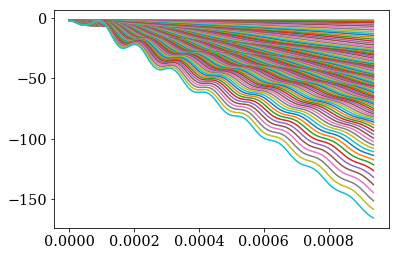

In [26]:
stepsizes = np.diff(τ_solve)

@numba.jit(nopython=True)
def solve(): 
    Y = np.zeros((len(τ_solve), 5, par.K_SOLVE))
    Y[0,:,:] = Y0
    for i, τi in enumerate(τ_solve[:-1]):
        #implement rK4:
        ss = stepsizes[i]
        k1 = ss*DY(τi,Y[i,:,:])
        k2 = ss*DY(τi+ss/2,Y[i,:,:]+k1/2)
        k3 = ss*DY(τi+ss/2,Y[i,:,:]+k2/2)
        k4 = ss*DY(τi+ss,Y[i,:,:]+k3)
        
        Y[i+1,:,:] = Y[i,:,:] + k1/6 + k2/3 + k3/3 + k4/6
    return Y
Y = solve()
plt.plot(τ_solve,Y[:,3,:])
plt.show()

In [33]:
"""1 fluid with fixed eval points"""
# set initial conditions
Φ0  = Φ[:,0] 
δɣ0 = δɣ[:,0] 
vɣ0 = vɣ[:,0] 
δd0 = δd[:,0] 
vd0 = vd[:,0] 

τ_solve_2 = np.interp(np.arange(0,len(τ_solve), 0.5),
                      np.arange(0,len(τ_solve)), τ_solve)

#compute background quantities
ℋa = ℋ(τ_solve_2)
aa =  a(τ_solve_2)
yba = yb(τ_solve_2)

Ωba = Ωb(τ_solve_2)
Ωɣa = Ωɣ(τ_solve_2)
Ωda = Ωc(τ_solve_2)

wda = np.interp(τ_solve_2, τ_solve, wd)
Dwda = np.interp(τ_solve_2, τ_solve, Dwd)
cs2da = np.array([np.interp(τ_solve_2, τ_solve, cs2d[i,:]) for i in range(K_SOLVE)])



Y0 = np.array([Φ0, δɣ0, vɣ0, δd0, vd0])
import numba
@numba.jit(nopython=True)
def DY(i, Y):
        dY = np.zeros((5,K_SOLVE))
        Φ = Y[0,:]
        δɣ = Y[1,:]
        vɣ = Y[2,:]
        δd = Y[3,:]
        vd = Y[4,:]
           
        ℋi = ℋa[i]
        ai = aa[i]
        ybi = yba[i]

        Ωbi = Ωba[i]
        Ωɣi = Ωɣa[i]
        Ωdi = Ωda[i]
        
        wdi = wda[i]
        Dwdi = Dwda[i]
        cs2di = cs2da[:,i]
        
        f = vd*Ωdi*(1+wdi) + 4./3.*Ωɣi*vɣ +  Ωbi*vɣ
        #DΦ
        dY[0,:]  = -ℋi*Φ + (3/2.*H0**2.*ai**2/k_solve)*f
        #Dδɣ
        dY[1,:] = -4./3.*k_solve*vɣ + 4*dY[0,:]
        #Dvɣ
        dY[2,:] = (-ℋi*ybi*vɣ + k_solve*δɣ/3)/(
            4./3. + ybi) + k_solve*Φ
        #Dδd
        dY[3,:] = -(1+wdi)*(k_solve*vd-3*dY[0,:]) -\
            3*ℋi*(cs2di-wdi)*δd
        # Dvd
        dY[4,:] = -ℋi*(1-3*wdi)*vd - vd*Dwdi/(1+wdi) +\
            k_solve*δd*cs2di/(1+wdi) + k_solve*Φ

        return dY

In [ ]:
stepsizes = np.diff(τ_solve)

@numba.jit(nopython=True)
def solve(): 
    Y = np.zeros((len(τ_solve), 5, par.K_SOLVE))
    Y[0,:,:] = Y0
    for i, τi in enumerate(τ_solve[:-1]):
        #implement rK4:
        ss = stepsizes[i]
        k1 = 2*ss*DY(2*i,Y[i,:,:])
        k2 = 2*ss*DY(2*i+1,Y[i,:,:]+k1/2)
        k3 = 2*ss*DY(2*i+1,Y[i,:,:]+k2/2)
        k4 = 2*ss*DY(2*i+2,Y[i,:,:]+k3)
        
        Y[i+1,:,:] = Y[i,:,:] + k1/6 + k2/3 + k3/3 + k4/6
    return Y
Y = solve()
plt.plot(τ_solve,Y[:,3,:])
plt.show()

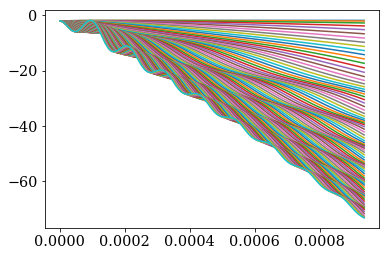

In [24]:
plt.plot(τ_solve,np.transpose(δd))
plt.show()

In [18]:
"""Precompute Bessel Functions"""
from scipy.special import spherical_jn
l_low = 2
l_high = 1200

l_list = np.array([i for i in range(2,50,1)]+[i for i in range(50,200,5)] + 
     [i for i in range(200, 2000, 20)])

L = len(l_list)
Cl = np.zeros(len(l_list))


k_list2  = np.linspace(k_low,k_high,K_INT)

JLK = np.array([
    spherical_jn(l, k_list2*(τ_now-τ_rec))
                for l in l_list])
DJLK = np.array([
    spherical_jn(l, k_list2*(τ_now-τ_rec), derivative=True) 
    for l in l_list])

In [19]:

k_grid = np.broadcast_to(k_list2,(len(l_list),K_INT))
@numba.jit(nopython=True)
def get_Cl():
    # first compute mode evolution:
    Yf = solve()[-1,:,:]
    SW = Yf[0,:] + Yf[1,:]/4
    DOP = Yf[2,:]
    SWsd = SW*np.exp(-(k_solve*τs)**2)
    DOPsd = DOP*np.exp(-(k_solve*τs)**2)
    
    # get the power spectrum
    SWfill = np.interp(k_list2, k_solve, SW)
    DOPfill = np.interp(k_list2, k_solve, DOP)
    Dl = SWfill*JLK + DOPfill*(DJLK-JLK/(2*k_list2*(τ_now-τ_rec)))

    T = np.exp(-2*(k_list2*τs)**2 - (.03*k_list2*τ_rec)**2)
    Cl_itgd = Dl**2 *T /k_list2
    Cl = integrate.trapz(k_grid, Cl_itgd)
    Cl_out = l_list*(l_list + 1)*Cl
    return -Cl_out

In [20]:
Cl = get_Cl()
%timeit Cl = get_Cl()

42.3 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


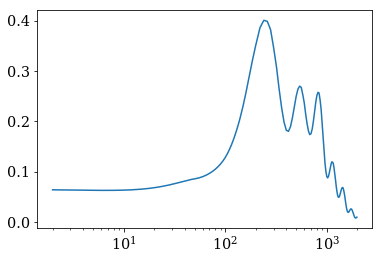

In [13]:
plt.semilogx(l_list,Cl)